# House Prices - Advanced Regression Techniques
In this task we will predict a house price based on linear regression model.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew
import seaborn as sns
from scipy import stats
import datetime

First we import the train set and the test set from google drive.

In [ ]:
path_train = '/content/gdrive/My Drive/Colab Notebooks/train.csv'
path_test = '/content/gdrive/My Drive/Colab Notebooks/test.csv'
from google.colab import drive
drive.mount('/content/gdrive')
csv_path_train = path_train
csv_path_test = path_test

df_train = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

Mounted at /content/gdrive


In [ ]:
df_train['Set'] = "Train"         #Adding label "Train" for the train set
df_test['Set'] = "Test"           #Adding label "Test" for the test set
df_test['SalePrice'] = -1         #Addind Sale price for the test set, so the test and train set have same dimension

df = pd.concat([df_train,df_test], axis=0, sort=False)  #concat the test and train sets
df.reset_index(inplace=True)

We observe the distribution of the SalePrices. As we can see from the figure, we obtain a normal distribution, a requirement for running linear regression.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


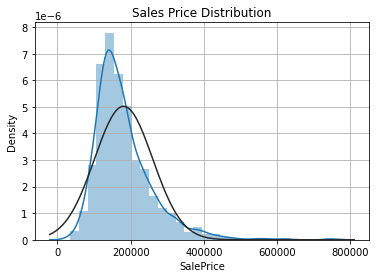

In [ ]:
sns.distplot(df_train.SalePrice, bins=30, fit=norm)
plt.grid()
plt.title("Sales Price Distribution")
plt.show()

We plot a QQ plot to observe the normal distribution.

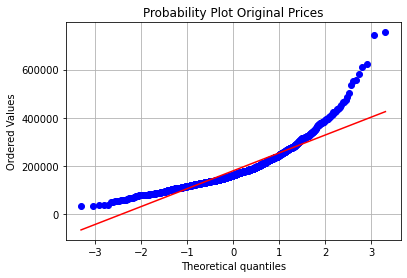

In [ ]:
stats.probplot(df_train.SalePrice, plot=plt)
plt.grid()
plt.title("Probability Plot Original Prices")
plt.show()

Insted of looking at the sale price we can manipulate the values by applying a non-decreasing function. In this section we will observe the distribution of log(SalePrice). There are few advantages to work with log function as we see later.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


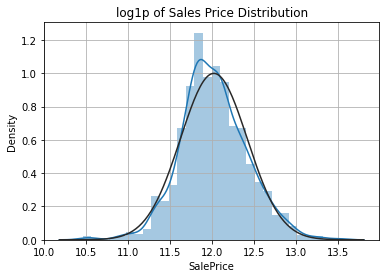

In [ ]:
sns.distplot(np.log1p(df_train.SalePrice), bins=30, fit=norm)
plt.grid()
plt.title("log1p of Sales Price Distribution")
plt.show()

As we can see log(SalePrice) obtain better normal distribution than SalePrice. There is less "leaks" in the edges.

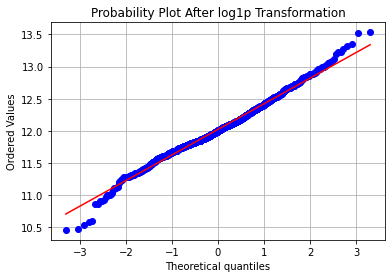

In [ ]:
stats.probplot(np.log1p(df_train.SalePrice), plot=plt)
plt.grid()
plt.title("Probability Plot After log1p Transformation")
plt.show()

Now we will start to process the data.

First we count the missing values.

In [ ]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print(i + ' : ' + str(round(df[i].isna().sum() / df.shape[0] * 100, 2)) + ' %')

MSZoning : 0.14 %
LotFrontage : 16.65 %
Alley : 93.22 %
Utilities : 0.07 %
Exterior1st : 0.03 %
Exterior2nd : 0.03 %
MasVnrType : 0.82 %
MasVnrArea : 0.79 %
BsmtQual : 2.77 %
BsmtCond : 2.81 %
BsmtExposure : 2.81 %
BsmtFinType1 : 2.71 %
BsmtFinSF1 : 0.03 %
BsmtFinType2 : 2.74 %
BsmtFinSF2 : 0.03 %
BsmtUnfSF : 0.03 %
TotalBsmtSF : 0.03 %
Electrical : 0.03 %
BsmtFullBath : 0.07 %
BsmtHalfBath : 0.07 %
KitchenQual : 0.03 %
Functional : 0.07 %
FireplaceQu : 48.65 %
GarageType : 5.38 %
GarageYrBlt : 5.45 %
GarageFinish : 5.45 %
GarageCars : 0.03 %
GarageArea : 0.03 %
GarageQual : 5.45 %
GarageCond : 5.45 %
PoolQC : 99.66 %
Fence : 80.44 %
MiscFeature : 96.4 %
SaleType : 0.03 %


There are several different methods for handling missing values. The simplest solution is to remove the entire row (or the entire column if it's missing enough values). However, removing an entire row also removes the non-missing fields, which isn't ideal. <br>
Another approach is to replace the missing values. The missing values can either be replaced with 0's (or "none" for strings) or the mean value of the column. The advantage of this solution is that no data is lost in the process.<br>
We chose the second approach:

In [ ]:
to_fill_none = ['Alley', 'BsmtCond','FireplaceQu', 'GarageType','GarageFinish','GarageQual', 'GarageCond', 'PoolQC','Fence','MiscFeature']
to_fill_0 = ['LotFrontage', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageCars','GarageYrBlt']
to_fill_freq = ['Electrical', 'MSZoning', 'Utilities', 'KitchenQual', 'Functional', 'Exterior1st','Exterior2nd','SaleCondition']
to_int = ['BsmtFullBath','BsmtHalfBath','Fireplaces','GarageCars']

In [ ]:
for i in to_fill_none:
    df[i].fillna("No", inplace=True)
for i in to_fill_0:
    df[i].fillna(0, inplace=True)
for i in to_fill_freq:
    df[i].fillna(df[i][:1460].mode().item(), inplace=True)
for i in to_int:
  df[i] = df[i].astype('int')

Then we perform logic calculation on the features.

In [ ]:
df['GarageAgeCat'] = df.GarageYrBlt.apply(lambda row: 'recent' if row >= 2000 else 'old')
df['BsmtFinSF'] = df.BsmtFinSF1 + df.BsmtFinSF2
df['Porch'] = df.ScreenPorch + df.EnclosedPorch + df.OpenPorchSF + df.WoodDeckSF
df['Total_surface'] = df.TotalBsmtSF + df['1stFlrSF'] + df['2ndFlrSF']
df['Age'] = df.YrSold - df.YearBuilt
df['RemodAge'] = df.YrSold - df.YearRemodAdd
df['GarageAge'] = df.YrSold - df.GarageYrBlt

Divide the features into 3 groups: drop, numeric and categorical.

All the features in drop group are no longer informative to the model, most of the features are used to calculate diffrent feature in the last section, so all the information is in the calculated feture (for instance the "Age").

In [ ]:
drop_cols = ['BsmtFinSF1','BsmtFinSF2','LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
             'MiscVal','MoSold','YrSold','1stFlrSF','2ndFlrSF' ,'BsmtUnfSF','TotalBsmtSF', 'YearBuilt','YearRemodAdd']
numeric = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF','GrLivArea','GarageArea','Porch','Total_surface', 'Age','RemodAge','OverallQual', 'GarageCars','GarageAge']
categorical = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LandSlope','Neighborhood','Condition1','Condition2',
               'BldgType','HouseStyle','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual',
               'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical', 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
               'BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd', 'Functional','Fireplaces','FireplaceQu','GarageType','GarageFinish',
               'GarageQual', 'GarageCond', 'PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition','LotConfig', 'GarageAgeCat']

In [ ]:
df.drop(drop_cols, inplace = True, axis=1)
df[categorical] = df[categorical].astype('category')
df[numeric] = df[numeric].astype('float')

We would like to ignore outliers in the data. So we drop the outlier information.

In [ ]:
df = df.drop(df[df.Set == "Train"][(df[df.Set == "Train"]['GrLivArea'] > 4000) & (df[df.Set == "Train"]['SalePrice'] < 250000)].index)

It is common in machine learning to normalize the data in order to work with balanced and relative small values.

In [ ]:
mm = RobustScaler()
df[numeric] = mm.fit_transform(df[numeric])

Now we encode all the categorical features. In order to apply a model on the data we have to work with numeric values instead of strings.

In [ ]:
df = pd.get_dummies(df,columns=categorical)

Split the data into train, validation and test sets.

In [ ]:
train = df[df.Set == 'Train']
test = df[df.Set == 'Test']
HouseIds = test.Id.to_list()
test = test.drop(['Id','Set',"SalePrice",'index'], axis = 1)
target = np.log1p(train.SalePrice)               #Apply log function on the SalePrice.
train = train.drop(['SalePrice','Id','Set','index'], axis=1)
train_set, val_set, target_train, target_val = train_test_split(train,target, test_size = 0.2) # random_state=10

We use 3 regressions model.

Linear regression

linear:
train score: 0.9591353760936457
val score: 0.8624709903677055
train RMSE error: 0.08062636343140996
val RMSE error: 0.14922656715639976


<function matplotlib.pyplot.show>

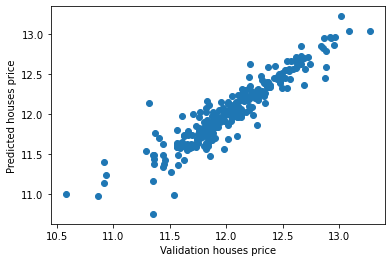

In [ ]:
linear = linear_model.LinearRegression().fit(train_set,target_train)
val_pred = linear.predict(val_set)

print("linear:")
print("train score:",linear.score(train_set,target_train))
print("val score:",linear.score(val_set,target_val))
print("train RMSE error:", np.sqrt(mean_squared_error(target_train,linear.predict(train_set))))
print("val RMSE error:", np.sqrt(mean_squared_error(target_val,val_pred)))

plt.scatter(target_val,val_pred)
plt.xlabel("Validation houses price")
plt.ylabel("Predicted houses price")
plt.show

Ridge regression

Ridge:
train score: 0.957301176502209
val score: 0.8828385062094174
train RMSE error: 0.08241595077118531
val RMSE error: 0.1377340889865455


<function matplotlib.pyplot.show>

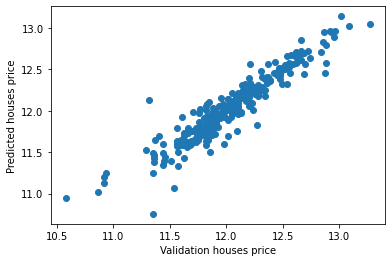

In [ ]:
Ridge = linear_model.Ridge().fit(train_set,target_train)
val_pred = Ridge.predict(val_set)

print("Ridge:")
print("train score:",Ridge.score(train_set,target_train))
print("val score:",Ridge.score(val_set,target_val))
print("train RMSE error:", np.sqrt(mean_squared_error(target_train,Ridge.predict(train_set))))
print("val RMSE error:", np.sqrt(mean_squared_error(target_val,val_pred)))

plt.scatter(target_val,val_pred)
plt.xlabel("Validation houses price")
plt.ylabel("Predicted houses price")
plt.show

Lasso regression

Lasso:
train score: 0.11996973834284341
val score: 0.12797669093023256
train RMSE error: 0.3741554899374088
val RMSE error: 0.37576215473414376


<function matplotlib.pyplot.show>

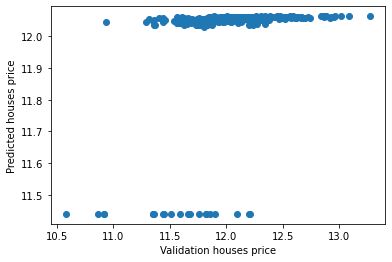

In [ ]:
Lasso = linear_model.Lasso().fit(train_set,target_train)
val_pred = Lasso.predict(val_set)

print("Lasso:")
print("train score:",Lasso.score(train_set,target_train))
print("val score:",Lasso.score(val_set,target_val))
print("train RMSE error:", np.sqrt(mean_squared_error(target_train,Lasso.predict(train_set))))
print("val RMSE error:", np.sqrt(mean_squared_error(target_val,val_pred)))

plt.scatter(target_val,val_pred)
plt.xlabel("Validation houses price")
plt.ylabel("Predicted houses price")
plt.show

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08639826543294227, tolerance: 0.014175219782320912
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7233125155015232, tolerance: 0.015063359864534259
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5201534066679434, tolerance: 0.015267783867074414
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Lasso:
The best alpha is: 1e-05
train score: 0.9589693583724876
val score: 0.8688139357247463
train RMSE error: 0.08078997484407989
val RMSE error: 0.1457447240135327


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.068e-01, tolerance: 1.855e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


<function matplotlib.pyplot.show>

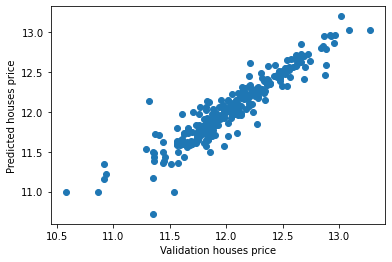

In [ ]:
hyperParam = np.linspace(0.00001,0.1,5)
Lasso = linear_model.LassoCV(alphas=hyperParam,max_iter=1000000).fit(train_set,target_train)
val_pred = Lasso.predict(val_set)

print("Lasso:")
print("The best alpha is:",Lasso.alpha_)
print("train score:",Lasso.score(train_set,target_train))
print("val score:",Lasso.score(val_set,target_val))
print("train RMSE error:", np.sqrt(mean_squared_error(target_train,Lasso.predict(train_set))))
print("val RMSE error:", np.sqrt(mean_squared_error(target_val,val_pred)))

plt.scatter(target_val,val_pred)
plt.xlabel("Validation houses price")
plt.ylabel("Predicted houses price")
plt.show

As we can see, the Ridge regression have the best results. Now we will do cross validation with Ridge regression.

Ridge:
The best alpha is: 6.040816326530612
train score: 0.9519286569639251
val score: 0.8985566709877489
train RMSE error: 0.08744730840273651
val RMSE error: 0.1281624311542212


<function matplotlib.pyplot.show>

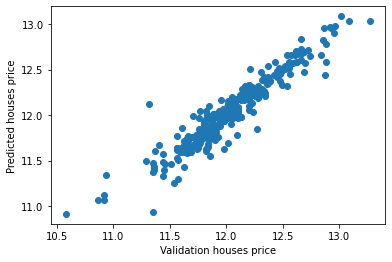

In [ ]:
hyperParam = np.linspace(1,20,50)
Ridge = linear_model.RidgeCV(alphas=hyperParam).fit(train_set,target_train)
val_pred = Ridge.predict(val_set)

print("Ridge:")
print("The best alpha is:",Ridge.alpha_)
print("train score:",Ridge.score(train_set,target_train))
print("val score:",Ridge.score(val_set,target_val))
print("train RMSE error:", np.sqrt(mean_squared_error(target_train,Ridge.predict(train_set))))
print("val RMSE error:", np.sqrt(mean_squared_error(target_val,val_pred)))

plt.scatter(target_val,val_pred)
plt.xlabel("Validation houses price")
plt.ylabel("Predicted houses price")
plt.show



In [ ]:
res = pd.DataFrame({"Id": HouseIds, "SalePrice": np.expm1(Ridge.predict(test))})
res.to_csv('submission.csv', index=False)